# Gradient Descent & Stochastic Gradient Descent (SDG)
In this notebook, we will discuss the effect of batch training.
You will see the  difference between full dataset and batch training.

Before we start, let's load the data and do the pre-processing again like in previous tasks.

In [1]:
import numpy as np
import os
from exercise_code.data.csv_dataset import CSVDataset
from exercise_code.data.csv_dataset import FeatureSelectorAndNormalizationTransform
from exercise_code.data.dataloader import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from exercise_code.networks.optimizer import SGD, sgd_momentum, Adam
from exercise_code.networks.loss import MSE
from exercise_code.networks.regression_net import RegressionNet
from exercise_code.solver import Solver
import warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
target_column = 'SalePrice'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
root_path = os.path.join(i2dl_exercises_path, "datasets", 'housing')
housing_file_path = os.path.join(root_path, "housing_train.csv")
download_url = 'https://cdn3.vision.in.tum.de/~dl4cv/housing_train.zip'

# Always make sure this line was run at least once before trying to
# access the data manually, as the data is downloaded in the
# constructor of CSVDataset.
train_dataset = CSVDataset(target_column=target_column, root=root_path, download_url=download_url, mode="train")

In [3]:
df = train_dataset.df

# Select only 2 features to keep plus the target column.
selected_columns = ['GrLivArea','GarageArea', target_column]
mn, mx, mean = df.min(), df.max(), df.mean()

column_stats = {}
for column in selected_columns:
    crt_col_stats = {'min' : mn[column],
                     'max' : mx[column],
                     'mean': mean[column]}
    column_stats[column] = crt_col_stats

transform = FeatureSelectorAndNormalizationTransform(column_stats, target_column)

def rescale(data, key = "SalePrice", column_stats = column_stats):
    """ Rescales input series y"""
    mx = column_stats[key]["max"]
    mn = column_stats[key]["min"]

    return data * (mx - mn) + mn

In [4]:
train_dataset = CSVDataset(mode="train", target_column=target_column, root=root_path, download_url=download_url, transform=transform)
val_dataset = CSVDataset(mode="val", target_column=target_column, root=root_path, download_url=download_url, transform=transform)
test_dataset = CSVDataset(mode="test", target_column=target_column, root=root_path, download_url=download_url, transform=transform)

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))


Number of training samples: 876
Number of validation samples: 292
Number of test samples: 292


## Hyerparameters
Here you can set your hyperparameters that are used across the notebook. You can play around how they have an effect on the training of your network.

In [5]:
lr = 5e-3
hidden_size = 4
std = .1

## Memory
First, let's see how much memory is needed during one iteration. In a forward pass, certain value of the layers should be stored into cache for later gradient calculation. And in a backward pass, the gradient has to be stored for parameter update. Here we discuss the memory these values occupy in GD and SGD. 

We can simply use `sys.getsizeof()` function to return the size of an object in bytes.

In [6]:

batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
# get one batch from train_dataloader
data = next(iter(train_dataloader))
X = data['features']
y = data['target']
model = RegressionNet(input_size=len(selected_columns)-1, hidden_size=hidden_size, std=std)
solver = Solver(model, train_dataloader, val_dataloader, learning_rate=lr,
                        loss_func=MSE(), optimizer=SGD)
solver._step(X, y, validation=False)

print('Memory required in bytes:', model.memory)

Memory required in bytes: 728


Now if we do an iteration on the full dataset, let's see how much memory is needed.

In [7]:
# use full batch
batch_size = len(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

data = next(iter(train_dataloader))
X = data['features']
y = data['target']
model = RegressionNet(input_size=len(selected_columns)-1, hidden_size=hidden_size, std=std)
solver = Solver(model, train_dataloader, val_dataloader, learning_rate=lr,
                        loss_func=MSE(), optimizer=SGD)
solver._step(X, y, validation=False)
print('Memory required in bytes:', model.memory)

Memory required in bytes: 28728


As you can see there is a huge difference in required memory during one iteration.
As the model capacity and the size of dataset increase, training on full batch will become impossible due to the high memory requirement.
You can try to change the hidden_size and batch_size to see how the required memory changes.

## Computation
The number of operation is also different for GD and SGD. Here we first discuss how to calculate the number of operation needed in forwad and backward pass.
### Forward Pass
In an affine layer, it is  simply a matrix multiplication. To go from layer 𝑖 to 𝑗, you do $𝑆_{mn}=𝑊_{md}∗𝑍_{dn}$. This operation has time complexity $O(m*d*n)$.

Then we apply activation function $𝑍_{mn}=f(𝑆_{mn})$. Since it is a element-wise operation, it has time complexity $O(m*n)$

### Backward Pass
The same as in forward pass. In affine layer, it calculates two gradients. One is wrt. weight $O(m*d*n)$ and onther one is wrt. the input $O(m*d*n)$.

In activation function, we have time complexity $O(m*n)$.

Here, you can see the different number of operation when using mini-batch and full batch in one iteration.

In [8]:

for batch_size in [32, len(train_dataset)]:
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    # get one batch from train_dataloader
    data = next(iter(train_dataloader))
    X = data['features']
    y = data['target']
    model = RegressionNet(input_size=len(selected_columns)-1, hidden_size=hidden_size, std=std)
    solver = Solver(model, train_dataloader, val_dataloader, learning_rate=lr,
                            loss_func=MSE(), optimizer=SGD)
    solver._step(X, y, validation=False)
    print('number of operation:', model.num_operation)

number of operation: 896
number of operation: 24528


## Training 
In this section, you will see how the loss per iteration changes when using SDG and GD. As SGD computes gradient on a small batch of data, the gradient will flactuate because it captures the noise in the batch. 

running with batch_size =  1
(Epoch 1 / 10) train loss: 0.025273; val loss: 0.027016
(Epoch 2 / 10) train loss: 0.013515; val loss: 0.012872
(Epoch 3 / 10) train loss: 0.013068; val loss: 0.013009
(Epoch 4 / 10) train loss: 0.013125; val loss: 0.012774
(Epoch 5 / 10) train loss: 0.013086; val loss: 0.012716
(Epoch 6 / 10) train loss: 0.013053; val loss: 0.012772
(Epoch 7 / 10) train loss: 0.013027; val loss: 0.012692
(Epoch 8 / 10) train loss: 0.013019; val loss: 0.012729
(Epoch 9 / 10) train loss: 0.012924; val loss: 0.012661
(Epoch 10 / 10) train loss: 0.012959; val loss: 0.012989
running with batch_size =  32
(Epoch 1 / 10) train loss: 0.025753; val loss: 0.026895
(Epoch 2 / 10) train loss: 0.020617; val loss: 0.018080
(Epoch 3 / 10) train loss: 0.015343; val loss: 0.013822
(Epoch 4 / 10) train loss: 0.013534; val loss: 0.013331
(Epoch 5 / 10) train loss: 0.013184; val loss: 0.013294
(Epoch 6 / 10) train loss: 0.013080; val loss: 0.012478
(Epoch 7 / 10) train loss: 0.013291; val los

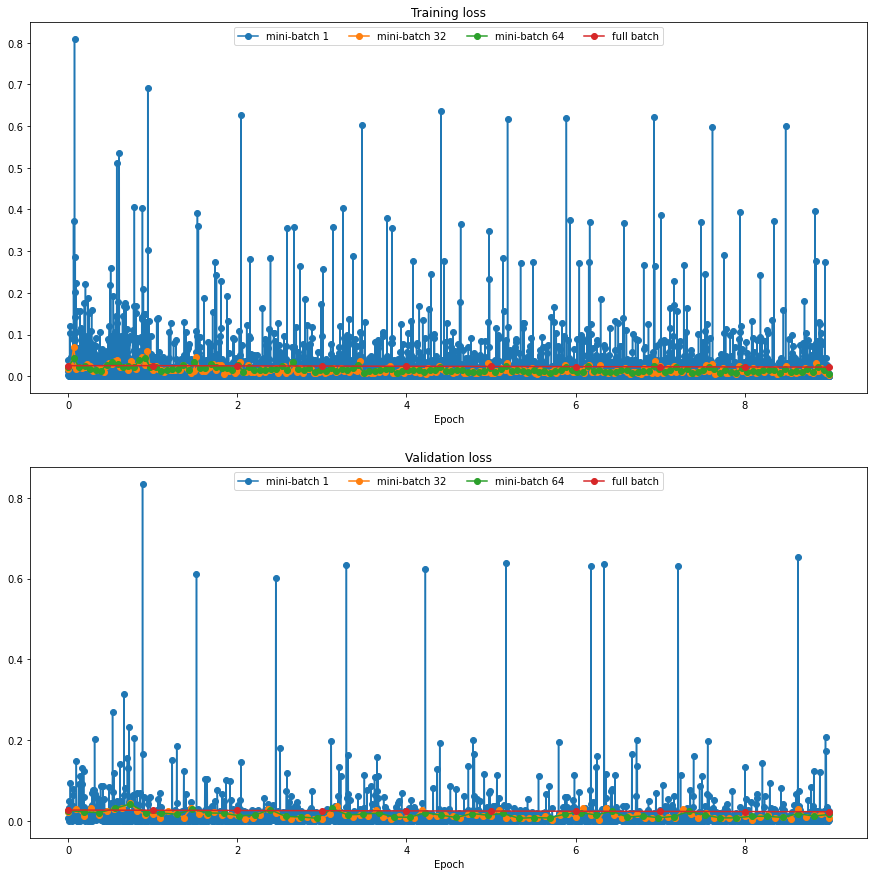

In [9]:

solvers = {}
num_computation = {}
train_mode = [*[('mini-batch {}'.format(i), i) for i in [1,  32, 64]], ('full batch', len(train_dataset))]

for i in train_mode:
    batch_size = i[1]
    print('running with batch_size = ', batch_size )
    model = RegressionNet(input_size=len(selected_columns)-1, hidden_size=hidden_size, std=std)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    solver = Solver(model, train_dataloader, val_dataloader, learning_rate=lr,
                        loss_func=MSE(), optimizer=SGD)

    solvers[i[0]] = solver
    solver.train(epochs=10)
    num_computation[i[0]] = solver.num_operation
ax1 = plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.xlabel('Epoch')

ax2 = plt.subplot(2, 1, 2)
plt.title('Validation loss')
plt.xlabel('Epoch')



for train_mode, solver in solvers.items():

    x1 = np.linspace(0, 9, len(solver.train_batch_loss))
    x2 = np.linspace(0, 9, len(solver.val_batch_loss))

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(x1, solver.train_batch_loss, '-o', label=train_mode)

    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(x2, solver.val_batch_loss, '-o', label=train_mode)

for i in [1, 2]:
    ax = plt.subplot(2, 1, i)
    ax.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

#### Which one is better for generalization? 
When you look at the validation loss, the SGD loss jumps up and down due to the noisy data.
In GD it does not have this issue, because it looks at the whole dataset. So it can learn the representation of the whole dataset, therefore has it better generalization.

## Converge speed

Now, let's see how the loss changes against the number of computation.
Training with smaller batch size will converge faster compared to full data. Why?

While in GD, you have to run through all the samples in your training set to do a single update for a parameter in a particular iteration. In SGD, on the other hand, you use only one of subset of training sample from your training set to do the update for a parameter in a particular iteration.
Using SGD will be faster because you use only subset of samples and it starts improving itself right away from that.

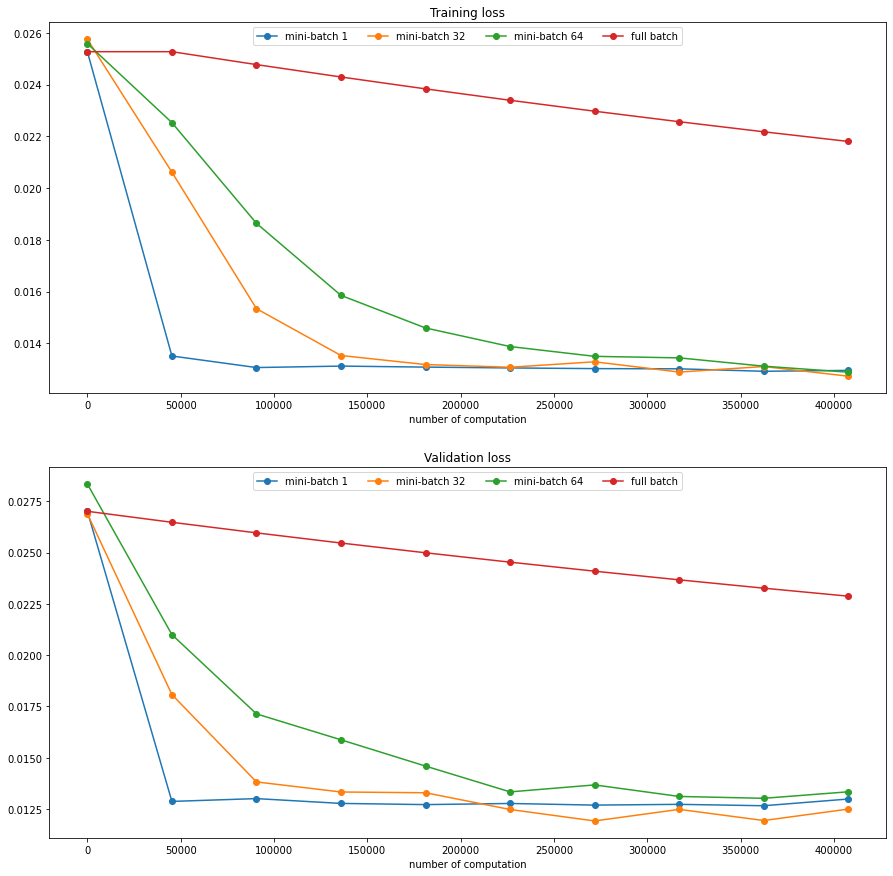

In [10]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.xlabel('number of computation')

plt.subplot(2, 1, 2)
plt.title('Validation loss')
plt.xlabel('number of computation')



for update_rule, solver in solvers.items():
    x = np.linspace(0, solver.num_operation, 10)

    ax1 = plt.subplot(2, 1, 1)
    plt.plot(x, solver.train_loss_history, '-o', label=update_rule)

    ax2 =plt.subplot(2, 1, 2)
    plt.plot(x, solver.val_loss_history, '-o', label=update_rule)


for i in [1, 2]:
    plt.subplot(2, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()
